# make a predictive model of all synapses
## (1) loading the machine learning library and setting environment variables

In [1]:
import os
import psutil

## set environment variables that you want
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# os.environ['PYTHONWARNINGS'] = 'ignore'
# os.environ['OMP_NUM_THREADS'] = "4" # the number of CPU cores
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit write-path-to-ml_library/ml_library.py"

## uncomment if you want to train on a specific GPU on a multi-gpu macine
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## uncomment If you want to train on CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["TF_DISABLE_MKL"]="1" # in my experience a natively compiled Tensorfllow is faster than MKL version

from ml_library import *
potental_connections_df = pd.read_csv('./Master_processed.csv')[['Presynaptic Neuron', 'Postsynaptic Neuron']]
# from IPython.display import Javascript
#Javascript("Jupyter.notebook.execute_cells([3]);")

TensorFlow version is 2.3.0


## (2) initial missing values interpolation
We used a random forest model to interpolate missing short-term plasticity parameters.

In [ ]:
model = assess_model(
    './SD_one_hot_pooled_features.csv', 
    './SD_one_hot_pooled_targets.csv',
    'SD_one_hot_predict_features', 
    potental_connections_df, 
    random_forest=True, 
    complete_stp=True)

We kept the original data and replaced missing values with random forest interpolations.

In [ ]:
folder = './random_forest'
predictions = []
for file in os.listdir(folder):
    if file.endswith('learned_targets_na_interpolated.csv'):
        np_file = pd.read_csv(os.path.join(folder, file)).to_numpy()
        predictions.append(np_file)
predictions = np.array(predictions)
df = pd.concat([
    pd.DataFrame(
        predictions.mean(axis=0),
        columns=['g.model', 'tau_d.model', 'tau_r.model', 'tau_f.model', 'U.model']),
    pd.read_csv('./SD_one_hot_pooled_targets.csv')
], axis=1)
# df.to_csv('./learned_targets_all_random_forest.csv', index=False)

df['g'    ] = np.where(df['g'    ]<=0, df['g.model'    ], df['g'    ])
df['tau_d'] = np.where(df['tau_d']<=0, df['tau_d.model'], df['tau_d'])
df['tau_r'] = np.where(df['tau_r']<=0, df['tau_r.model'], df['tau_r'])
df['tau_f'] = np.where(df['tau_f']<=0, df['tau_f.model'], df['tau_f'])
df['U'    ] = np.where(df['U'    ]<=0, df['U.model'    ], df['U'    ])

df[['g', 'tau_d', 'tau_r', 'tau_f', 'U']].to_csv(
    './SD_one_hot_pooled_targets_interpolated_missing_values_01_pass_averaged.csv', index=False)

## (3) missing values interpolation using deep learning model
We used the target matrix completed with the random forest model to train deep learning models. We trained one hundred models (you may uncomment javascript code to automate this process). Each model produced a learned target matrix containing the interpolations.

02-pass-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=30-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015
17:32:26 fitting model_00002
17:32:28 before training loss: 122.90 maape: 79.06
17:37:13 restored best loss: 37.55, best mean_arctan_absolute_percentage_error: 30.22 at epoch 4435.
17:37:20 iteration: 01 loss: 29.84 maape: 23.67 ob: 52 bio-plausible: True 
17:37:20 training ended


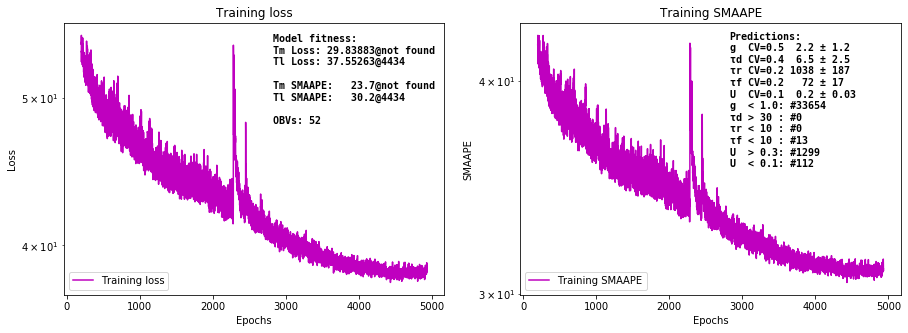

In [3]:
model = assess_model(
    './SD_one_hot_pooled_features_NA_ISI_set_to_50.csv',
    './SD_one_hot_pooled_targets_interpolated_missing_values_01_pass_averaged.csv',
    'SD_one_hot_predict_features',
    potental_connections_df,
    random_forest=False, complete_stp=False,
    passage_num=2, # just for naming folders
    loss_threshold=55, loss_goal = 37,
    maape_threshold=41, maape_goal = 30)
# Javascript("setTimeout(()=>Jupyter.notebook.execute_cells([0]), 1000); Jupyter.notebook.kernel.restart();")

We made an averaged learned target matrix to replace missing target values.

In [4]:
passage_num = 2
folder = f'./{passage_num:0>2}-pass-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=30-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015'
predictions = []
for file in os.listdir(folder):
    if file.endswith('learned_targets_na_interpolated.csv'):
        np_file = pd.read_csv(os.path.join(folder, file)).to_numpy()
        predictions.append(np_file)
predictions = np.array(predictions)
df = pd.concat([
    pd.DataFrame(
        predictions.mean(axis=0),
        columns=['g.model', 'tau_d.model', 'tau_r.model', 'tau_f.model', 'U.model']),
    pd.read_csv('./SD_one_hot_pooled_targets.csv')
], axis=1)
# df.to_csv(f'./learned_targets_all_{passage_num:0>2}_pass_averaged.csv', index=False)

df['g'    ] = np.where(df['g'    ]<=0, df['g.model'    ], df['g'    ])
df['tau_d'] = np.where(df['tau_d']<=0, df['tau_d.model'], df['tau_d'])
df['tau_r'] = np.where(df['tau_r']<=0, df['tau_r.model'], df['tau_r'])
df['tau_f'] = np.where(df['tau_f']<=0, df['tau_f.model'], df['tau_f'])
df['U'    ] = np.where(df['U'    ]<=0, df['U.model'    ], df['U'    ])

df[['g', 'tau_d', 'tau_r', 'tau_f', 'U']].to_csv(
    f'./SD_one_hot_pooled_targets_interpolated_missing_values_{passage_num:0>2}_pass_averaged.csv', index=False)

## (4) prediction power assesment
After generating the completed matrix, we checked the prediction power of the model with k-means cross-validation on each passage.

In [ ]:
k_means_cross_validation(
    './SD_one_hot_pooled_features_NA_ISI_set_to_50.csv', 
    './SD_one_hot_pooled_targets_interpolated_missing_values_02_pass_averaged.csv')

21:50:27 starting processing fold #1
22:05:04 starting processing fold #2
22:19:51 starting processing fold #3
22:34:30 starting processing fold #4


## (5) Final model
On each passage, we lowered the loss_goal and maape_goal to make more accurate models.

31-pass-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=27-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015
16:10:50 fitting model_00001
16:10:51 before training loss: 130.90 maape: 84.27
16:15:47 restored best loss: 35.91, best mean_arctan_absolute_percentage_error: 29.04 at epoch 4627.
16:15:54 iteration: 01 loss: 27.52 maape: 21.84 ob: 45 bio-plausible: True 
16:15:54 training ended


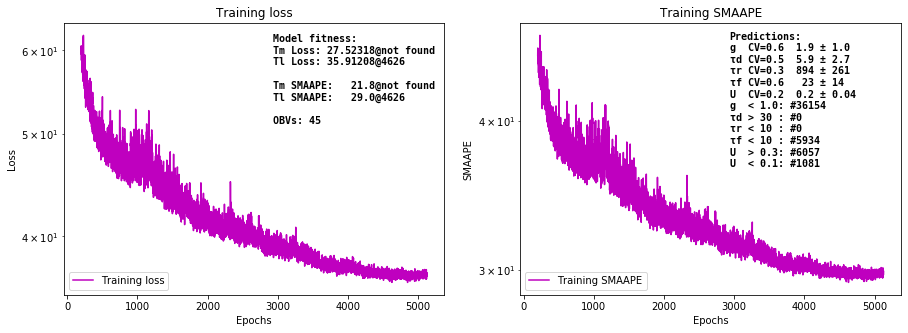

In [7]:
model = assess_model(
    './SD_one_hot_pooled_features_NA_ISI_set_to_50.csv',
    './SD_one_hot_pooled_targets_interpolated_missing_values_30_pass_averaged.csv',
    'SD_one_hot_predict_features',
    potental_connections_df, 
    random_forest=False, 
    passage_num=31 # just for naming folders)
# Javascript("setTimeout(()=>Jupyter.notebook.execute_cells([0]), 1000); Jupyter.notebook.kernel.restart();")

## (6) prediction power of the final model
After thirty passages, the prediction power of the models did not improve.

In [ ]:
k_means_cross_validation(
    './SD_one_hot_pooled_features_NA_ISI_set_to_50.csv', 
    './SD_one_hot_pooled_targets_interpolated_missing_values_30_pass_averaged.csv')

## (7) jack-knife
We used jack-knife method, for a better assessment of the prediction power.

31-pass-JK-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=27-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015
20:23:14 fitting model_00002
20:23:16 before training loss: 132.65 maape: 85.04
20:28:08 restored best loss: 36.10, best mean_arctan_absolute_percentage_error: 29.26 at epoch 4045.
20:28:15 iteration: 01 loss: 28.20 maape: 22.48 ob: 47 bio-plausible: True 
20:28:15 training ended


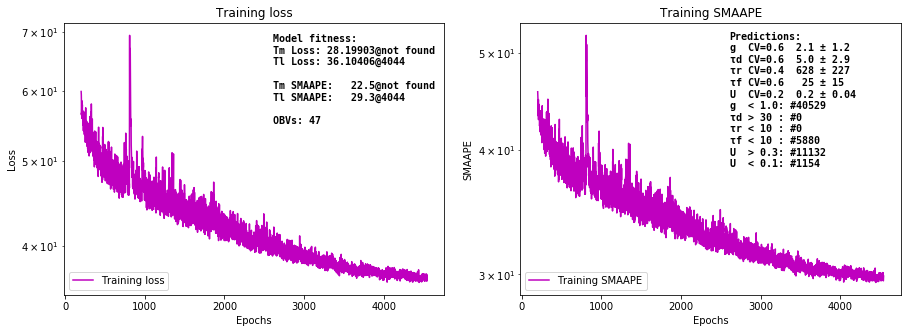

In [3]:
model = assess_model(
    './SD_one_hot_pooled_features_NA_ISI_set_to_50.csv',
    './SD_one_hot_pooled_targets_interpolated_missing_values_30_pass_averaged.csv',
    'SD_one_hot_predict_features',
    potental_connections_df, 
    jack_knife=True,
    passage_num=31)

### concatenate jackknife data

In [ ]:
features = pd.read_csv('./SD_one_hot_pooled_features.csv')
targets = pd.read_csv('./SD_one_hot_pooled_targets.csv')
data_row_number = len(features)
folder = './31-pass-JK-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=27-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015'
counter = 0
if os.path.exists(os.path.join(folder, '0_jk_all.csv')):
    os.remove(os.path.join(folder, '0_jk_all.csv'))

for i in range(data_row_number):
    file = f'model_{i+1:0>5}_weights.csv'
    if not os.path.exists(os.path.join(folder, file)):
        # print(f'{file} is missing')
        counter+=1
if counter>0:
    print(f'{counter} files remaining')

file_ending = 'csv'
predictions = []
for file in os.listdir(folder):
    if file.endswith(file_ending):
        df = pd.read_csv(os.path.join(folder, file))
        df = pd.concat([
            df[['n', 'g.model', 'tau_d.model', 'tau_r.model', 'tau_f.model', 'U.model']],
            targets.iloc[[int(df.n - 1)]].reset_index(drop=True),
            features.iloc[[int(df.n - 1)]].reset_index(drop=True)
        ], axis=1)
        predictions.append(df)
pd.concat(predictions).to_csv(os.path.join(folder, '0_jk_all.csv'), index=False)

## (8) average predictions in thirty-two different experimental settings

In [ ]:
folder = './31-pass-L=[8192-512-128-512-8192]-mish-SMAPE-SMAAPE=30-DO=[0.5-0.5-0.05-0.5-0.5]-GN=0.20-Max=1.0-L2w=0.001-BN-b=2621-e=9999x4-p=500-LROPp=100-LROPf=0.9-LA-ADAMWm89-lr=0.015'
if not os.path.exists(os.path.join(folder, 'Analysis')):
    os.mkdir(os.path.join(folder, 'Analysis'))
def average_predictions(folder, file_ending):
    predictions = []
    for file in os.listdir(folder):
        if file.endswith(file_ending):
            predictions.append(
                pd.read_csv(os.path.join(folder, file)).drop(
                    ['Unnamed: 0', 'Presynaptic Neuron', 'Postsynaptic Neuron'], axis=1).to_numpy())
    predictions = np.array(predictions)
    column_names = ['g', 'tau_d', 'tau_r', 'tau_f', 'U']
    neuron_pairs_columns = pd.read_csv('../Master_processed.csv')[['Presynaptic Neuron', 'Postsynaptic Neuron']]
    pd.concat([
        neuron_pairs_columns,
        pd.DataFrame(predictions.std(axis=0)/predictions.mean(axis=0), columns=column_names)
    ], axis=1).to_csv(os.path.join(folder, 'Analysis', 'cv_' + file_ending))
    pd.concat([
        neuron_pairs_columns,
        pd.DataFrame(predictions.std(axis=0), columns=column_names)
    ], axis=1).to_csv(os.path.join(folder, 'Analysis', 'std_' + file_ending))
    means_df = pd.concat([
        neuron_pairs_columns,
        pd.DataFrame(predictions.mean(axis=0), columns=column_names)
    ], axis=1)
    means_df.to_csv(os.path.join(folder, 'Analysis', 'means_' + file_ending))
    matrix_plot(means_df, os.path.join(folder, 'Analysis', 'means_' + file_ending[:-3] + 'png'))
    pd.concat([
        neuron_pairs_columns,
        pd.DataFrame(predictions.min(axis=0), columns=column_names)
    ], axis=1).to_csv(os.path.join(folder, 'Analysis', 'min_' + file_ending))
    pd.concat([
        neuron_pairs_columns,
        pd.DataFrame(predictions.max(axis=0), columns=column_names)
    ], axis=1).to_csv(os.path.join(folder, 'Analysis', 'max_' + file_ending))
#     return  pd.DataFrame(
#         (predictions.std(axis=0)/predictions.mean(axis=0)).mean(axis=0).reshape((1, 5)), 
#         columns=['g', 'tau_d', 'tau_r', 'tau_f', 'U'])
    
average_predictions(folder, 'center_Vh=-40_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T22_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_FeMale_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P14_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P30_Mice_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=0.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=100.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T27_Th350_Male_P56_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T32_Th350_Male_P30_Rat_Cli=4_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P0_ISI50_T32_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-60_P1_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vh=-80_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vss=-40_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vss=-60_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'center_Vss=-80_P0_ISI50_T27_Th350_Male_P30_Rat_Cli=107_gluconatei=11.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Female_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Female_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Female_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Female_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Male_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Male_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Male_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T22_Th350_Male_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Female_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Female_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Female_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Female_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Male_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Male_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Male_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vh=-60_P0_ISI50_T32_Th350_Male_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Female_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Female_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Female_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Female_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Male_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Male_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Male_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T22_Th350_Male_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Female_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Female_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Female_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Female_P56_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Male_P14_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Male_P14_Rat_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Male_P56_Mice_Cli=4_gluconatei=0.csv')
average_predictions(folder, 'Vss=-60_P0_ISI50_T32_Th350_Male_P56_Rat_Cli=4_gluconatei=0.csv')